In [9]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import warnings
import sqlite3
import re
import string
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
data = pd.read_csv('dataset/Train.csv',low_memory=False)

In [3]:
data.shape

(6034195, 4)

In [4]:
data.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


### EDA

In [4]:
data['title_length'] = data.Title.apply(lambda x: len(x))

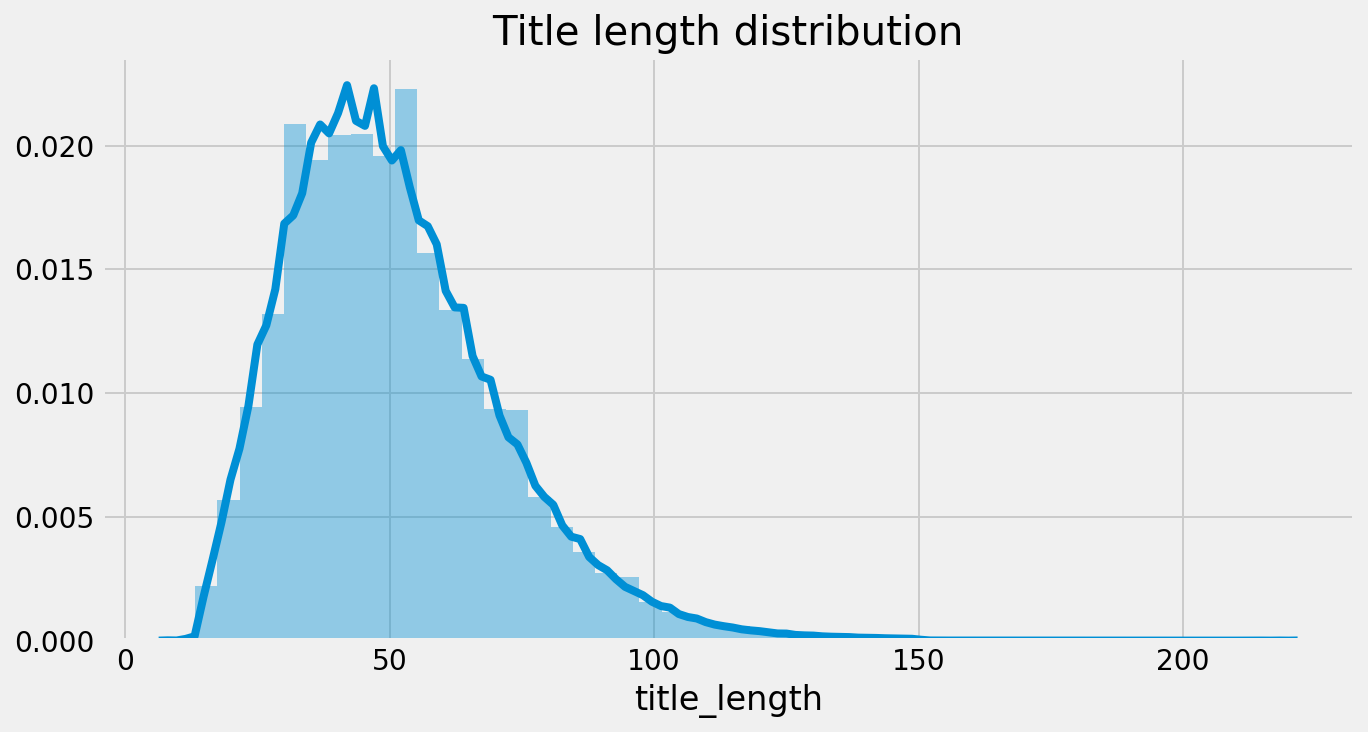

In [7]:
sns.distplot(data.title_length);
plt.title('Title length distribution');

How does title length controls some of the popular tags in the questions? Let's see some of the most popular tags.

In [8]:
tags = []
for each in tqdm(data.Tags):
    try:
        tags.extend(each.split())
    except AttributeError:
        pass

In [9]:
uTags = np.unique(tags)
uTags.shape  ## Number of unique tags in the dataset
tagCounters = Counter(tags)
top_tags = pd.DataFrame.from_dict(tagCounters, orient='index', columns=['counts'])
top_tags.index.name = 'tag'
top_tags.reset_index(inplace=True)
top_tags.sort_values(by='counts', ascending=False, inplace=True)

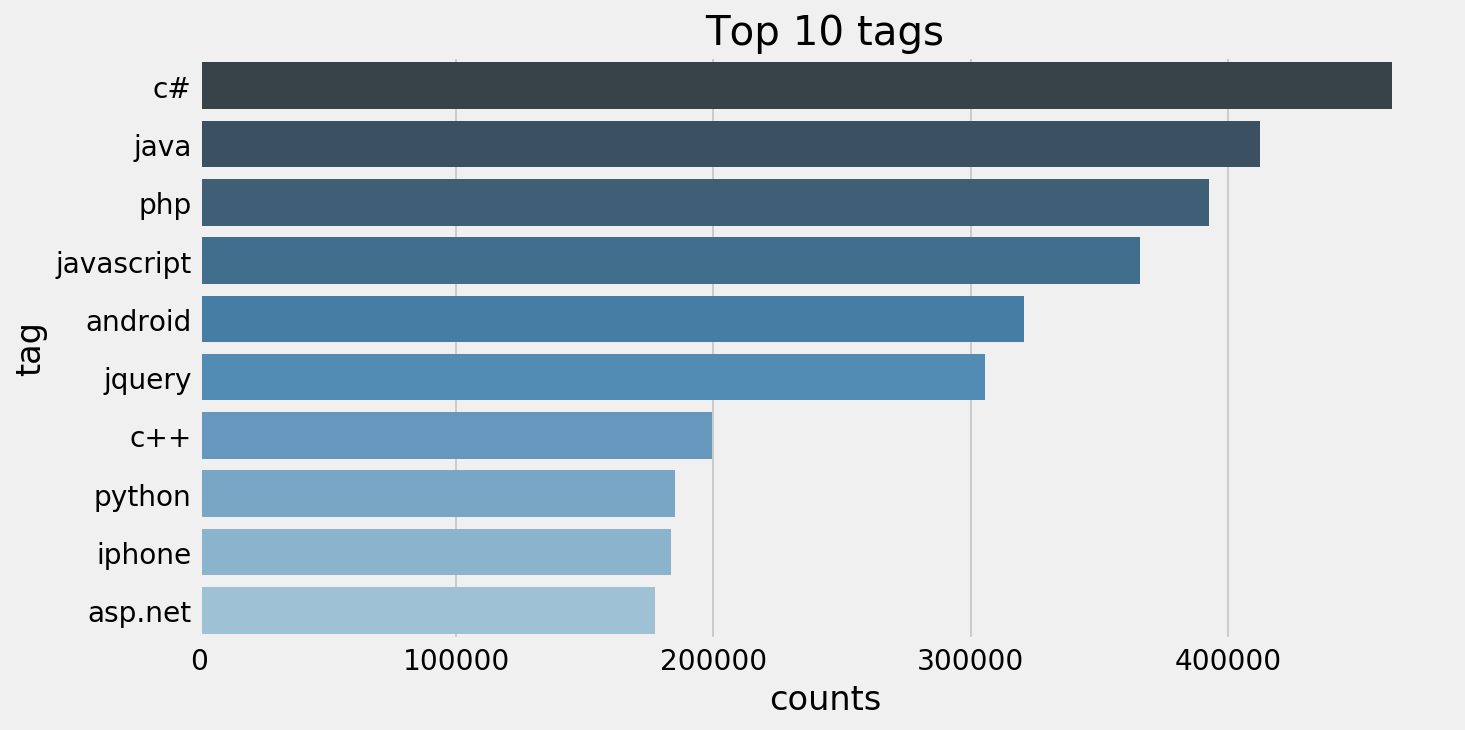

In [10]:
sns.barplot(x='counts', y='tag', palette='Blues_d',
            data=top_tags.head(10));
plt.title('Top 10 tags');

In [8]:
data[pd.isna(data.Tags)]

,Id,Title,Body,Tags,title_length
895318,895319,Do we really need NULL?,<blockquote>\n <p><strong>Possible Duplicate:...,NaN,23
1030863,1030864,Page cannot be null. Please ensure that this o...,<p>I get this error when i remove dynamically ...,NaN,110
1467813,1467814,How do Germans call null,"<p>In german null means 0, so how do they call...",NaN,24
1927902,1927903,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</...",NaN,44
2614271,2614272,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,NaN,42
3196708,3196709,Handle NullObjects,<p>I have done quite a bit of research on best...,NaN,18
4144270,4144271,Find all values that are not null and not in a...,<p>I am running into a problem which results i...,NaN,58
4391252,4391253,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<block...,NaN,42


In [9]:
data = data[~pd.isna(data.Tags)]
data.reset_index(drop=True, inplace=True)

In [10]:
def get_best_tag(tags):
    tags = tags.split()
    if 'c#' in tags:
        return 'c#'
    elif 'java' in tags:
        return 'java'
    elif 'php' in tags:
        return 'php'
    elif 'javascript' in tags or 'jquery' in tags:
        return 'js'
    elif 'c++' in tags:
        return 'c++'
    elif 'android' in tags:
        return 'android'
    elif 'python' in tags:
        return 'python'
    else:
        return 'other'

In [11]:
data['best_tags'] = data.Tags.apply(get_best_tag)

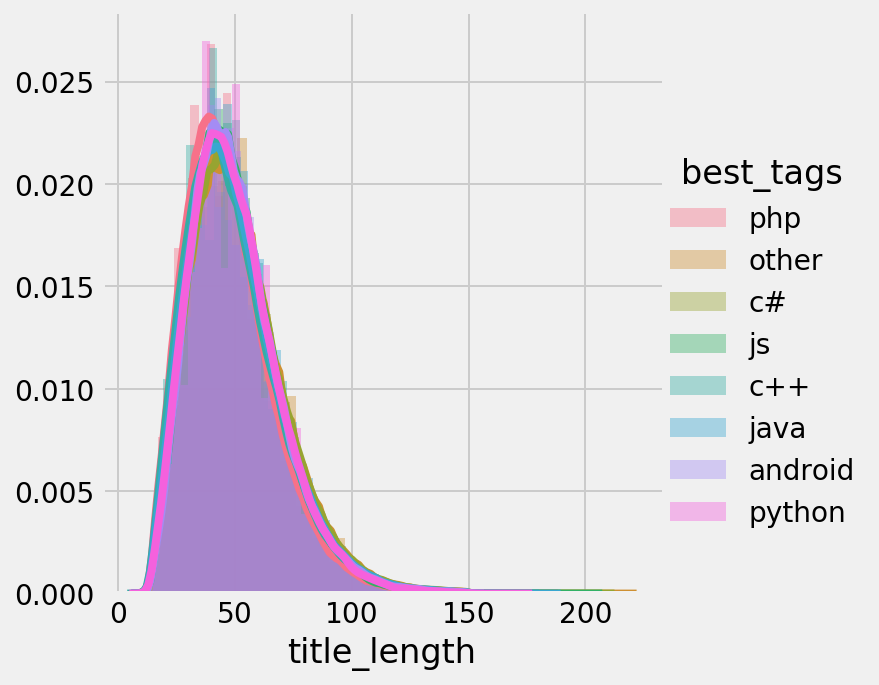

In [12]:
sns.FacetGrid(data, hue='best_tags', height=5).map(sns.distplot, 
                                                   'title_length').add_legend();

**Conclusion:** As we can see that the distributions are overlapped, mostly `title_length` won't be important feature very much.

In [13]:
data['body_length'] = data.Body.apply(lambda x: len(x))

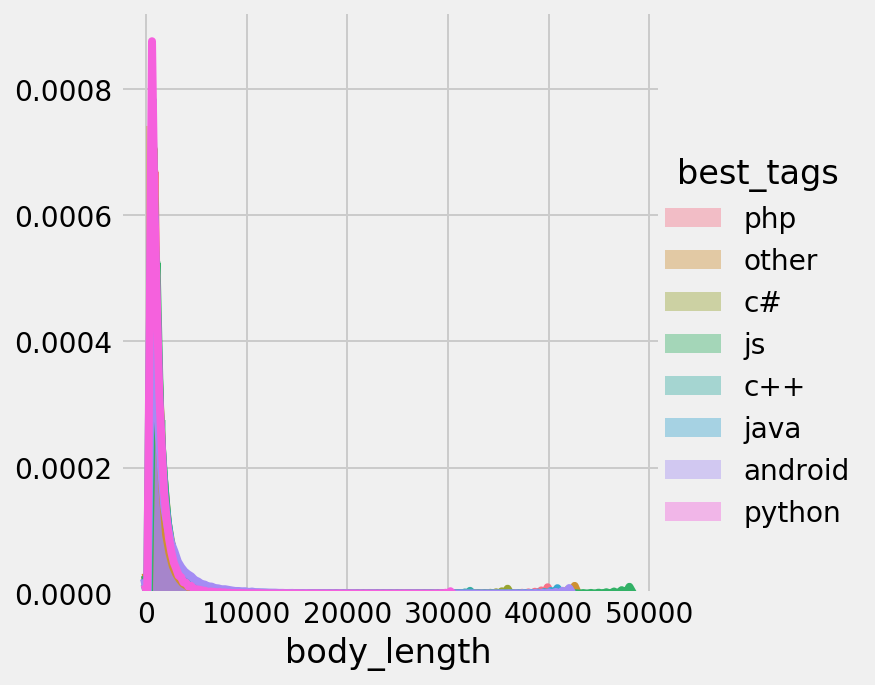

In [14]:
sns.FacetGrid(data, hue='best_tags', height=5).map(sns.distplot, 
                                                   'body_length').add_legend();

**Conclusion**: Body length also seems to unimportant features

### Handling the duplicates

In [15]:
data.drop_duplicates(subset={'Title', 'Body', 'Tags'}, 
                     keep='first', inplace=True)

In [16]:
data.shape

(4206307, 7)

### Text processing

In [17]:
import re

In [20]:
from tqdm import tqdm

In [18]:
def get_between_tags(body, tag):
    regex = f'<{tag}>(.*?)</{tag}>'
    codes = re.findall(regex, body, flags=re.DOTALL|re.MULTILINE)
    code = ""
    for each in codes:
        code += each
        code += '\n'
    return code

In [10]:
tqdm.pandas()

In [23]:
data['code'] = data.Body.progress_apply(lambda x: get_between_tags(x, 'code'))

100%|██████████| 4206307/4206307 [01:06<00:00, 63407.31it/s]


In [24]:
data.head()

,Id,Title,Body,Tags,title_length,best_tags,body_length,code
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,63,php,408,
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,58,other,360,
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,40,other,13532,Error in model.frame.default(formula = expert_...
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,45,c#,562,
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,36,php,990,function modify(.......)\n{\n $mcontact = fil...


In [25]:
data['body'] = data.Body.progress_apply(lambda x: get_between_tags(x, 'p'))

100%|██████████| 4206307/4206307 [01:16<00:00, 54966.98it/s]


In [26]:
data.drop('Body', axis=1, inplace=True)

In [27]:
data.head()

,Id,Title,Tags,title_length,best_tags,body_length,code,body
0,1,How to check if an uploaded file is an image w...,php image-processing file-upload upload mime-t...,63,php,408,,I'd like to check if an uploaded file is an im...
1,2,How can I prevent firefox from closing when I ...,firefox,58,other,360,,"In my favorite editor (vim), I regularly use c..."
2,3,R Error Invalid type (list) for variable,r matlab machine-learning,40,other,13532,Error in model.frame.default(formula = expert_...,I am import matlab file and construct a data f...
3,4,How do I replace special characters in a URL?,c# url encoding,45,c#,562,,"This is probably very simple, but I simply can..."
4,5,How to modify whois contact details?,php api file-get-contents,36,php,990,function modify(.......)\n{\n $mcontact = fil...,"using this modify function, displays warning m..."


In [28]:
print(data.code[4])

function modify(.......)
{
  $mcontact = file_get_contents( "https://test.httpapi.com/api/contacts/modify.json?auth-userid=$uid&amp;auth-password=$pass&amp;contact-id=$cid&amp;name=$name &amp;company=$company&amp;email=$email&amp;address-line-1=$street&amp;city=$city&amp;country=$country&amp;zipcode=$pincode&amp;phone-cc=$countryCodeList[$phc]&amp;phone=$phone" );

  $mdetails = json_decode( $mcontact, true );

  return $mdetails;
}

  [function.file-get-contents]: failed to open stream: HTTP request failed!
  HTTP/1.0 400 Bad request in /home/gfdgfd/public_html/new_one/customer/account/class.whois.php
  on line 49




Code can giveaway the programmning language very easily what programming language it is and may be also an indicator of some tags. So lets see how much code is important.

In [32]:
!ls dataset/

cleaned.db  finalTrain.db  SampleSubmission.csv  Test.csv  Train.csv


In [35]:
conn = sqlite3.connect('./dataset/cleaned.db')
data.to_sql('train', conn, if_exists='replace', index=False)
conn.close()

In [2]:
conn = sqlite3.connect('./dataset/cleaned.db')

In [3]:
data = pd.read_sql_query('SELECT * FROM train', conn)

In [4]:
data.head()

,Id,Title,Tags,title_length,best_tags,body_length,code,body
0,1,How to check if an uploaded file is an image w...,php image-processing file-upload upload mime-t...,63,php,408,,I'd like to check if an uploaded file is an im...
1,2,How can I prevent firefox from closing when I ...,firefox,58,other,360,,"In my favorite editor (vim), I regularly use c..."
2,3,R Error Invalid type (list) for variable,r matlab machine-learning,40,other,13532,Error in model.frame.default(formula = expert_...,I am import matlab file and construct a data f...
3,4,How do I replace special characters in a URL?,c# url encoding,45,c#,562,,"This is probably very simple, but I simply can..."
4,5,How to modify whois contact details?,php api file-get-contents,36,php,990,function modify(.......)\n{\n $mcontact = fil...,"using this modify function, displays warning m..."


In [5]:
data.shape

(4206307, 8)

In [6]:
def possible_cpp(code):
    regex1 = re.compile(r'#\s*include')
    regex2 = re.compile(r'#\s*ifndef')
    if regex1.search(code) or regex2.search(code):
        return True
    else:
        return False

In [11]:
data['possbleCpp'] = data.code.progress_apply(possible_cpp)

100%|██████████| 4206307/4206307 [00:15<00:00, 267024.75it/s]


In [12]:
data['possbleJava'] = data.code.progress_apply(lambda x: 'public static void main' in x)

100%|██████████| 4206307/4206307 [00:07<00:00, 560749.88it/s]


In [13]:
data['possbleC#'] = data.code.progress_apply(lambda x: 'public static void Main' in x)

100%|██████████| 4206307/4206307 [00:08<00:00, 508010.42it/s]


### Cleaning the Text futher

#### Lowercase all the letters

In [14]:
data['Title'] = data.Title.progress_apply(lambda x: x.lower())
data['body'] = data.body.progress_apply(lambda x: x.lower())

100%|██████████| 4206307/4206307 [00:11<00:00, 366176.57it/s]


#### Removing the stopwords

In [15]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from nltk.tokenize import word_tokenize

In [16]:
def remove_stopwords_and_punctuation(text):
    ct = []
    for each in word_tokenize(text):
        if each not in stopwords.words('english') and each not in string.punctuation:
            ct.append(each)
    return ' '.join(ct)

In [17]:
data['Title'] = data.Title.progress_apply(remove_stopwords_and_punctuation)

100%|██████████| 4206307/4206307 [1:54:37<00:00, 611.60it/s]  


In [18]:
data.head()

,Id,Title,Tags,title_length,best_tags,body_length,code,body,possbleCpp,possbleJava,possbleC#
0,1,check uploaded file image without mime type,php image-processing file-upload upload mime-t...,63,php,408,,i'd like to check if an uploaded file is an im...,False,False,False
1,2,prevent firefox closing press ctrl-w,firefox,58,other,360,,"in my favorite editor (vim), i regularly use c...",False,False,False
2,3,r error invalid type list variable,r matlab machine-learning,40,other,13532,Error in model.frame.default(formula = expert_...,i am import matlab file and construct a data f...,False,False,False
3,4,replace special characters url,c# url encoding,45,c#,562,,"this is probably very simple, but i simply can...",False,False,False
4,5,modify whois contact details,php api file-get-contents,36,php,990,function modify(.......)\n{\n $mcontact = fil...,"using this modify function, displays warning m...",False,False,False


In [65]:
body_part_1 = data['body'][0:500_000]
body_part_2 = data['body'][500_000:1_000_000]
body_part_3 = data['body'][1_000_000:1_500_000]
body_part_4 = data['body'][1_500_000:2_000_000]
body_part_5 = data['body'][2_000_000:2_500_000]
body_part_6 = data['body'][2_500_000:3_000_000]
body_part_7 = data['body'][3_000_000:3_500_000]
body_part_8 = data['body'][3_500_000:4_000_000]
body_part_9 = data['body'][4_000_000:]

In [69]:
conn = sqlite3.connect('dataset/Samples.db')

In [70]:
body_part_1.to_sql('part1', conn)
body_part_2.to_sql('part2', conn)
body_part_3.to_sql('part3', conn)
body_part_4.to_sql('part4', conn)
body_part_5.to_sql('part5', conn)
body_part_6.to_sql('part6', conn)
body_part_7.to_sql('part7', conn)
body_part_8.to_sql('part8', conn)
body_part_9.to_sql('part9', conn)

In [ ]:
data['body'] = data.body.progress_apply(remove_stopwords_and_punctuation)
# This step was split into several small dataframes
# and then split into multiple concurrent processes.
# We used 2000001 data points almost 50% of the total points.
# After cleaning we put the data into db called sampleCleaned.db

In [19]:
conn = sqlite3.connect('./dataset/Samples.db')

In [20]:
data_sample_1 = pd.read_sql_query('SELECT * FROM part1', conn)
data_sample_2 = pd.read_sql_query('SELECT * FROM part2', conn)
data_sample_3 = pd.read_sql_query('SELECT * FROM part3', conn)
data_sample_4 = pd.read_sql_query('SELECT * FROM part4', conn)
data_sample_5 = pd.read_sql_query('SELECT * FROM part5', conn)
data_sample_6 = pd.read_sql_query('SELECT * FROM part6', conn)
data_sample_7 = pd.read_sql_query('SELECT * FROM part7', conn)
data_sample_8 = pd.read_sql_query('SELECT * FROM part8', conn)
data_sample_9 = pd.read_sql_query('SELECT * FROM part9', conn)

In [21]:
bodies = pd.concat([data_sample_1, data_sample_2, data_sample_3, data_sample_4,
                 data_sample_5, data_sample_6, data_sample_7, data_sample_8, data_sample_9], ignore_index=True)

In [22]:
assert(bodies.shape[0] == 4206307)

In [24]:
bodies.head()

,index,body
0,0,i'd like to check if an uploaded file is an im...
1,1,"in my favorite editor (vim), i regularly use c..."
2,2,i am import matlab file and construct a data f...
3,3,"this is probably very simple, but i simply can..."
4,4,"using this modify function, displays warning m..."


In [27]:
data['body'] = bodies.body

In [28]:
data.head()

,Id,Title,Tags,title_length,best_tags,body_length,code,body,possbleCpp,possbleJava,possbleC#
0,1,check uploaded file image without mime type,php image-processing file-upload upload mime-t...,63,php,408,,i'd like to check if an uploaded file is an im...,False,False,False
1,2,prevent firefox closing press ctrl-w,firefox,58,other,360,,"in my favorite editor (vim), i regularly use c...",False,False,False
2,3,r error invalid type list variable,r matlab machine-learning,40,other,13532,Error in model.frame.default(formula = expert_...,i am import matlab file and construct a data f...,False,False,False
3,4,replace special characters url,c# url encoding,45,c#,562,,"this is probably very simple, but i simply can...",False,False,False
4,5,modify whois contact details,php api file-get-contents,36,php,990,function modify(.......)\n{\n $mcontact = fil...,"using this modify function, displays warning m...",False,False,False


### Stemming the data

In [29]:
stemmer = SnowballStemmer("english")

In [30]:
def stemIt(text):
    ct = []
    for each in word_tokenize(text):
        ct.append(stemmer.stem(each))
    return ' '.join(ct)

In [31]:
data['Title'] = data.Title.progress_apply(stemIt)

100%|██████████| 4206307/4206307 [17:12<00:00, 4075.82it/s]


In [34]:
data['body'] = data.body.progress_apply(stemIt)

100%|██████████| 4206307/4206307 [2:53:36<00:00, 403.81it/s]  


In [35]:
data.Title[20]

'cancer recoveri rate 1920'

In [36]:
data.body[20]

"< strong > relat : < /strong > < a href= '' http : //skeptics.stackexchange.com/questions/3131/have-any-cures-been-invented-since-the-1950s-or-so '' > have ani “ cure ” been invent sinc the 1950 's or so ? < /a > i ran across the movi < a href= '' http : //cutpoisonburn.com/ '' > cut poison burn < /a > , who 's abstract is as follow : cut poison burn is a controversi , eye open , and sometim heartbreak documentari that put the busi of cancer treatment under the microscop . follow the frustrat journey of critic ill cancer patient as they tri to navig the confus and danger maze of treatment and encount formid obstacl in the “ cancer industri complex. ” a compel critiqu of the influenc of medic monopoli , the power of pharmaceut compani and govern agenc , cut poison burn is essenti view for anyon and everyon touch by cancer . the movi may advoc ( have n't watch the whole thing ) some kind of new , pennies-per-sess treatment a la < a href= '' http : //skeptics.stackexchange.com/questions/

##### clean the html and other junk text from the data

In [37]:
def clean_body(text):
    regex = r"href=\s*''\s*http\s*.*?''"
    return re.sub(regex, '', text)

In [38]:
data['body'] = data.body.progress_apply(clean_body)
data['body'] = data.body.progress_apply(lambda x: re.sub('/a', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('/strong', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('\'s', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('“', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('”', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('\.', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('\'ve', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('\'d', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('\'m', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('[0-9]+', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub("img\s*src=\s.*''", '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('-', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('=', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub("''", '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub("'", '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub("br/", '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub("/code", '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('http\s*.*?\s', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub(',', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('/p', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('`', '', x))
data['body'] = data.body.progress_apply(lambda x: re.sub('’', '', x))

100%|██████████| 4206307/4206307 [00:11<00:00, 374728.59it/s]


In [42]:
data['body'] = data.body.apply(lambda x: re.sub('<', '', x))
data['body'] = data.body.apply(lambda x: re.sub('>', '', x))
data['body'] = data.body.apply(lambda x: re.sub(':', '', x))
data['body'] = data.body.apply(lambda x: re.sub('\(', '', x))
data['body'] = data.body.apply(lambda x: re.sub('\)', '', x))
data['body'] = data.body.apply(lambda x: re.sub('\?', '', x))

In [44]:
data.head()

,Id,Title,Tags,title_length,best_tags,body_length,code,body,possbleCpp,possbleJava,possbleC#
0,1,check upload file imag without mime type,php image-processing file-upload upload mime-t...,63,php,408,,i like to check if an upload file is an imag ...,False,False,False
1,2,prevent firefox close press ctrl-w,firefox,58,other,360,,in my favorit editor vim i regular use ctrl...,False,False,False
2,3,r error invalid type list variabl,r matlab machine-learning,40,other,13532,Error in model.frame.default(formula = expert_...,i am import matlab file and construct a data f...,False,False,False
3,4,replac special charact url,c# url encoding,45,c#,562,,this is probabl veri simpl but i simpli can n...,False,False,False
4,5,modifi whoi contact detail,php api file-get-contents,36,php,990,function modify(.......)\n{\n $mcontact = fil...,use this modifi function display warn mesag p...,False,False,False


In [48]:
train = data[0:2000_001]
validation =data[2000_001:]

In [53]:
conn = sqlite3.connect('./dataset/finalTrain.db')

In [ ]:
train.to_sql('train', conn, index=False, if_exists='replace')

In [ ]:
validation.to_sql('validation', conn, index=False, if_exists='replace')

In [ ]:
conn.close()